# Wine Classifier with KNN

In [1]:
import logging 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ( train_test_split, GridSearchCV ) 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import ( MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder ) 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ( 
        accuracy_score, 
        f1_score, 
        matthews_corrcoef, 
        classification_report, 
        ConfusionMatrixDisplay ) 
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
logger = logging.getLogger()
logger.setLevel(logging.INFO)


### **1. Data loading** **Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/refs/heads/main/winequality-red.csv"
df_raw = pd.read_csv(url, sep=';')
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [3]:
df_raw['quality'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1599 entries, 0 to 1598
Series name: quality
Non-Null Count  Dtype
--------------  -----
1599 non-null   int64
dtypes: int64(1)
memory usage: 12.6 KB


In [4]:
df_raw['quality'].unique()

array([5, 6, 7, 4, 8, 3])

In [5]:
df_raw.sample(10, random_state=2025)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1462,6.8,0.640,0.03,2.3,0.075,14.0,31.0,0.99545,3.36,0.58,10.4,6
1162,8.5,0.320,0.42,2.3,0.075,12.0,19.0,0.99434,3.14,0.71,11.8,7
412,7.1,0.735,0.16,1.9,0.100,15.0,77.0,0.99660,3.27,0.64,9.3,5
527,7.0,0.380,0.49,2.5,0.097,33.0,85.0,0.99620,3.39,0.77,11.4,6
1176,6.5,0.880,0.03,5.6,0.079,23.0,47.0,0.99572,3.58,0.50,11.2,4
1139,8.2,0.510,0.24,2.0,0.079,16.0,86.0,0.99764,3.34,0.64,9.5,6
1556,6.6,0.880,0.04,2.2,0.066,12.0,20.0,0.99636,3.53,0.56,9.9,5
971,10.4,0.260,0.48,1.9,0.066,6.0,10.0,0.99724,3.33,0.87,10.9,6
88,9.3,0.390,0.44,2.1,0.107,34.0,125.0,0.99780,3.14,1.22,9.5,5
1128,10.0,0.430,0.33,2.7,0.095,28.0,89.0,0.99840,3.22,0.68,10.0,5


### **2. Data preprocessing** **Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [6]:
df_baking = df_raw.copy()
df_baking.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [9]:
#Encodeo Manual para transformar la columna quality a label

quality_mapping = {
    3: 0,
    4: 0,
    5: 1,
    6: 1,
    7: 2,
    8: 2
}

df_baking['label'] = df_baking['quality'].map(quality_mapping)

# Ahora verificar la codificación

print(df_baking['label'].unique())

print(df_baking['label'].value_counts())

[1 2 0]
label
1    1319
2     217
0      63
Name: count, dtype: int64


In [10]:
df = df_baking.copy()

### **3. Exploratory Data Analysis** 
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [11]:
df_train, df_test = train_test_split( 
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=2025 ) 

df_train, df_val = train_test_split( 
    df_train, 
    test_size=0.20, 
    stratify=df_train['label'], 
    random_state=2025 ) 

df_train.reset_index(drop=True, inplace=True) 
df_val.reset_index(drop=True, inplace=True) 
df_test.reset_index(drop=True, inplace=True) 

df_train.shape, df_val.shape, df_test.shape


((1023, 13), (256, 13), (320, 13))

In [12]:
display(df_train.describe(include='number').T) 



,count,mean,std,min,25%,50%,75%,max
fixed acidity,1023.0,8.287097,1.677825,4.70000,7.100000,7.9000,9.100000,15.60000
volatile acidity,1023.0,0.521153,0.181197,0.12000,0.390000,0.5100,0.630000,1.58000
citric acid,1023.0,0.273617,0.192980,0.00000,0.100000,0.2600,0.430000,0.78000
residual sugar,1023.0,2.571359,1.452939,0.90000,1.900000,2.2000,2.600000,15.40000
chlorides,1023.0,0.087086,0.045776,0.01200,0.070000,0.0790,0.090000,0.46700
free sulfur dioxide,1023.0,15.971652,10.549398,1.00000,7.500000,13.0000,21.000000,72.00000
total sulfur dioxide,1023.0,46.432551,33.340617,6.00000,22.000000,38.0000,62.000000,289.00000
density,1023.0,0.996684,0.001885,0.99007,0.995525,0.9967,0.997825,1.00369
pH,1023.0,3.313001,0.148226,2.88000,3.220000,3.3100,3.400000,4.01000
sulphates,1023.0,0.658661,0.167390,0.37000,0.550000,0.6200,0.720000,1.98000


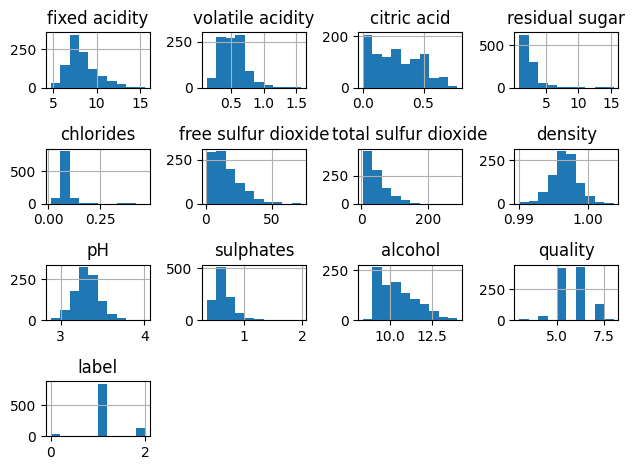

In [13]:
#Análisis Univariado
df_train.hist()
plt.tight_layout()
plt.show() 


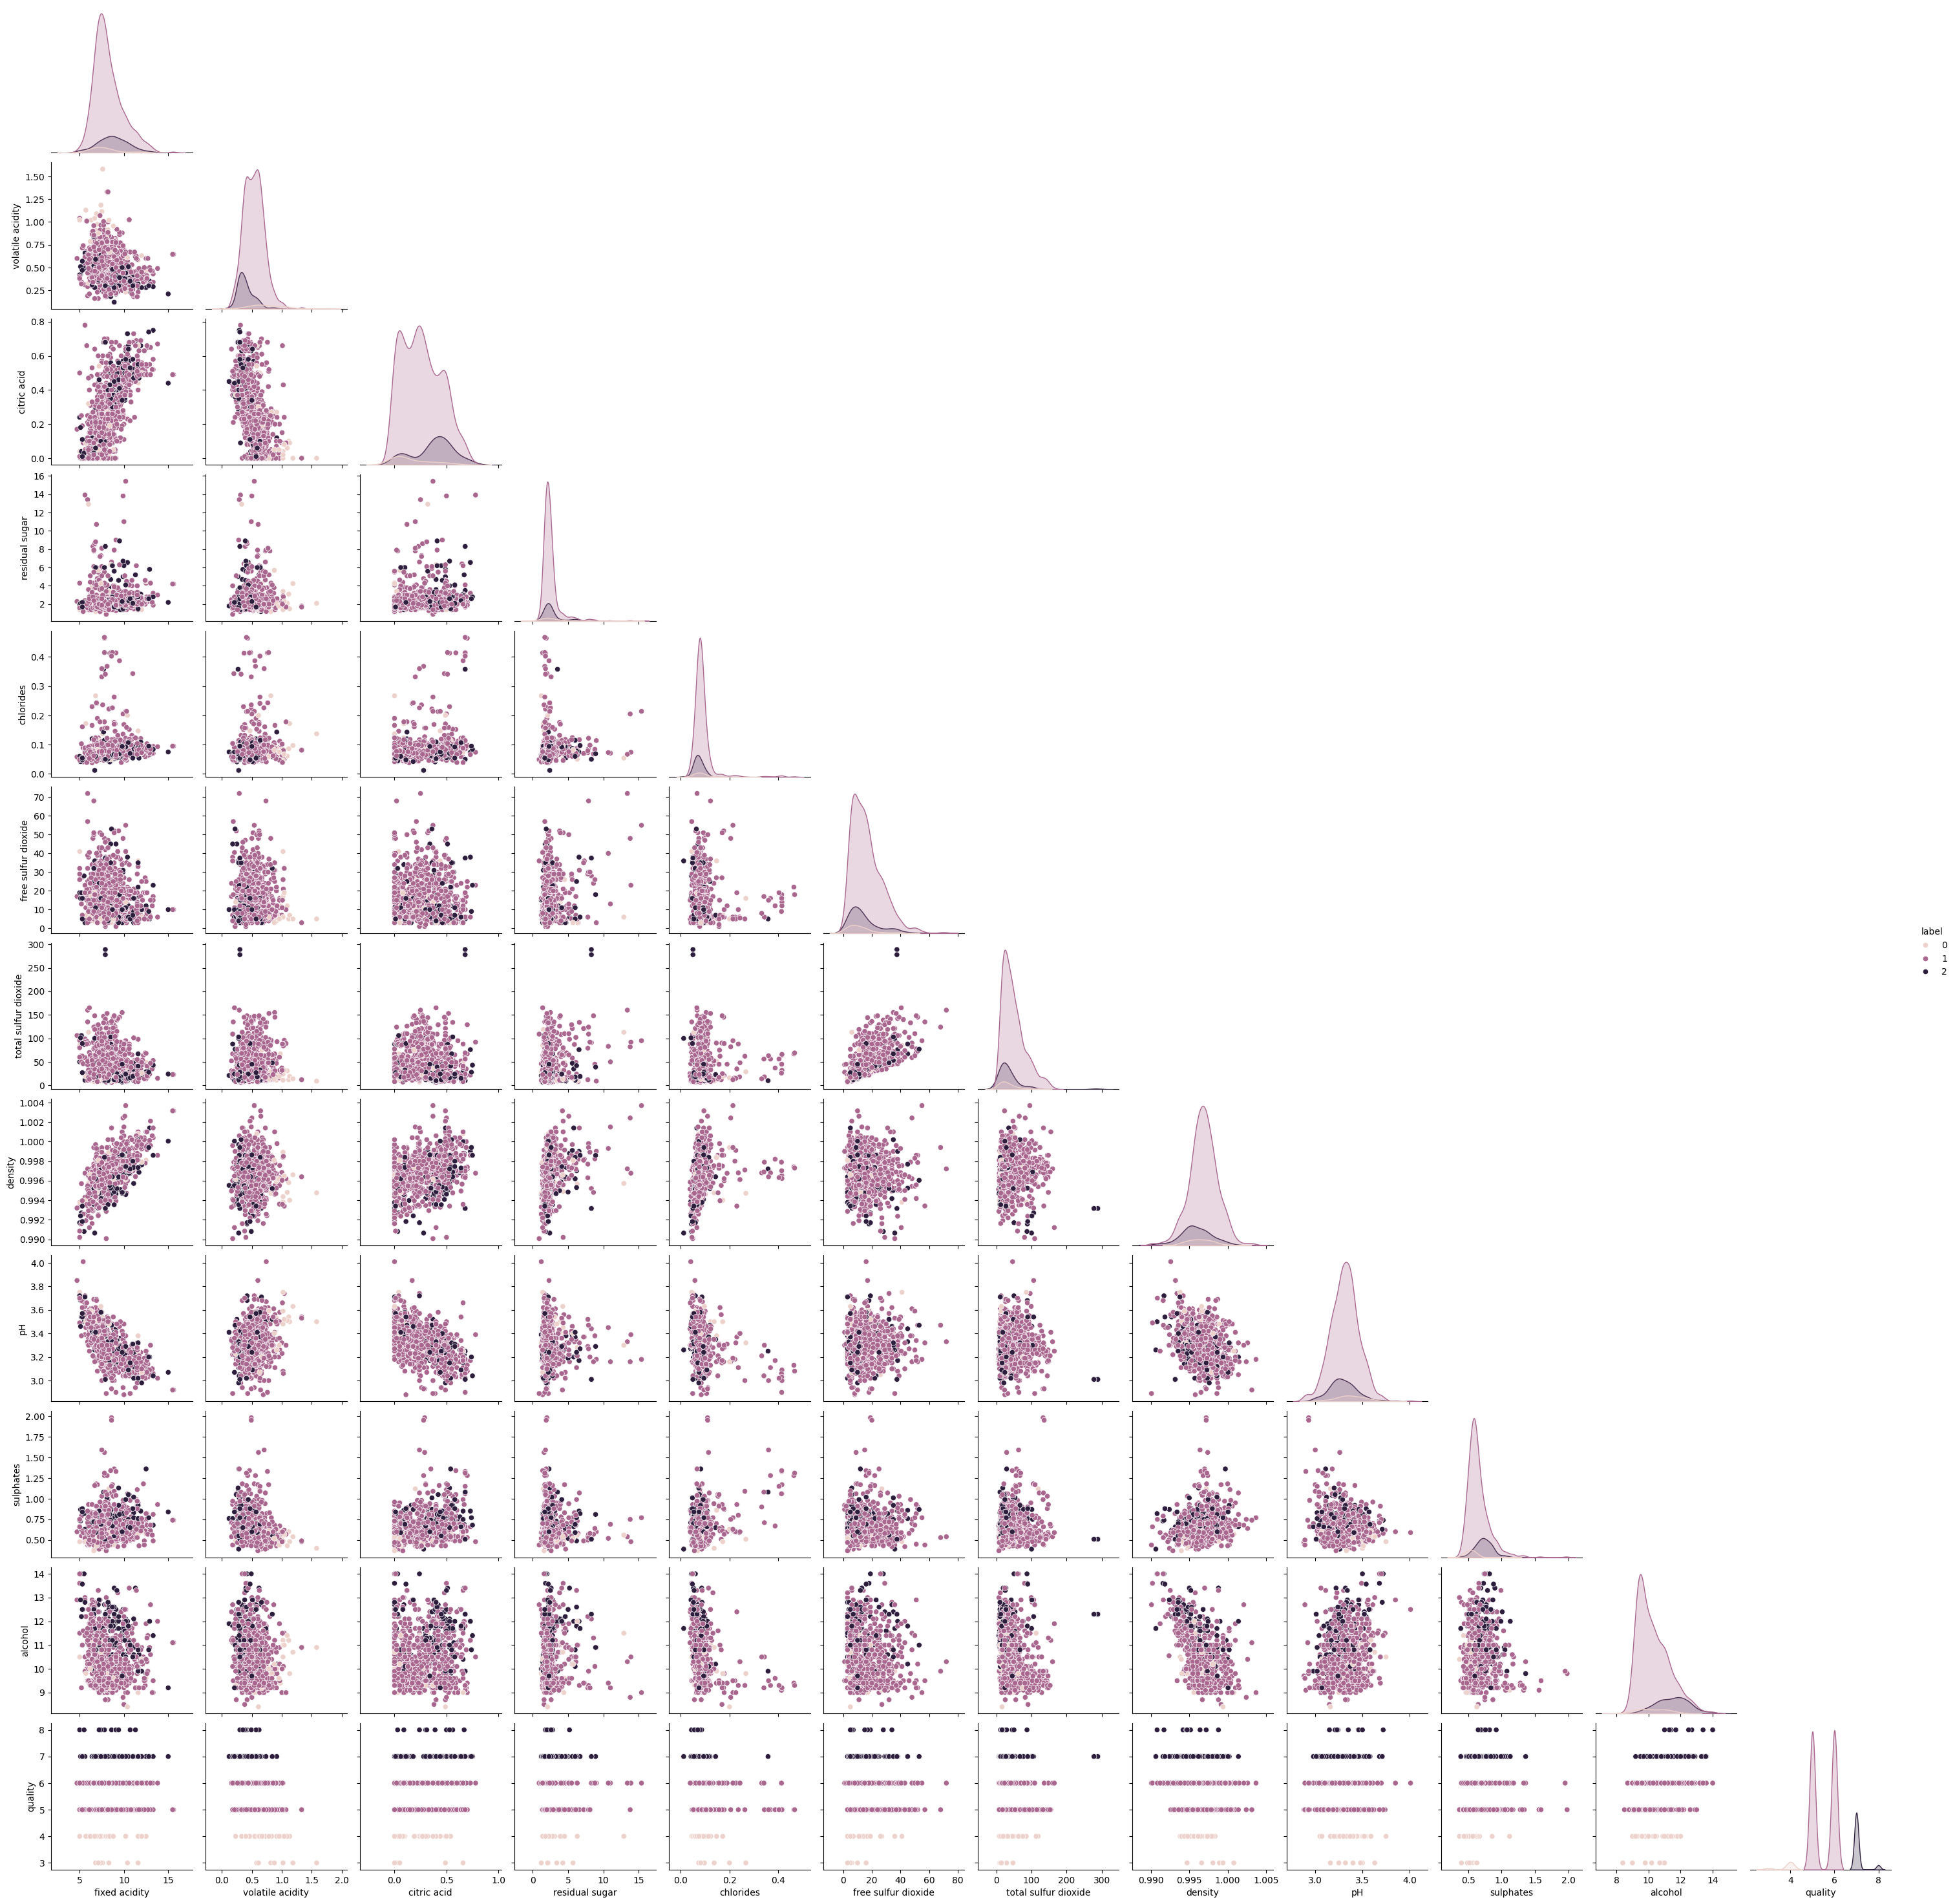

In [14]:
# análisis bivariado
sns.pairplot(df_train,hue = "label", corner=True)
plt.show()


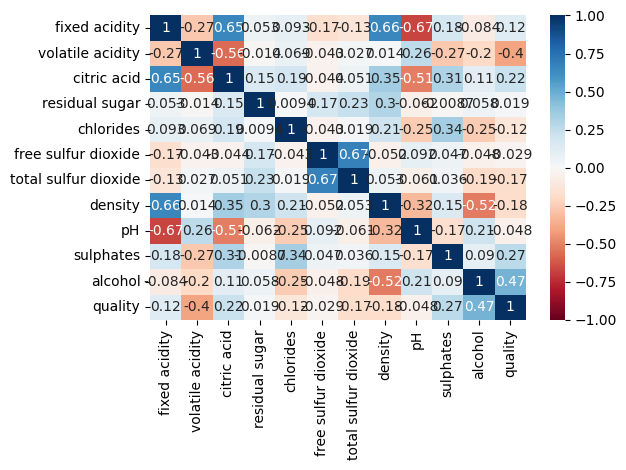

In [15]:
# Correlación
sns.heatmap(
    df_train.drop(columns=['label']).corr(), 
    vmin=-1, vmax=1, annot=True, cmap='RdBu'
)
plt.tight_layout()
plt.show()


### **4. Machine learning** **Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [16]:
#División del data set en Train, Val, Test
X_train = df_train.drop(['quality', 'label'], axis=1) 
y_train = df_train['label'] 
X_val = df_val.drop(['quality', 'label'], axis=1) 
y_val = df_val['label'] 
X_test = df_test.drop(['quality', 'label'], axis=1) 
y_test = df_test['label']


In [17]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Train the model with an initial k value
initial_k = 5
knn_model = KNeighborsClassifier(n_neighbors=initial_k)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [19]:
# Evaluate performance
y_pred = knn_model.predict(X_test_scaled)
print(f"\nKNN Model Performance (k={initial_k}):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=0))


KNN Model Performance (k=5):
Accuracy: 0.8406

Confusion Matrix:
[[  0  13   0]
 [  1 252  11]
 [  0  26  17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.87      0.95      0.91       264
           2       0.61      0.40      0.48        43

    accuracy                           0.84       320
   macro avg       0.49      0.45      0.46       320
weighted avg       0.80      0.84      0.81       320



In [20]:
# 3. Optimize k
k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

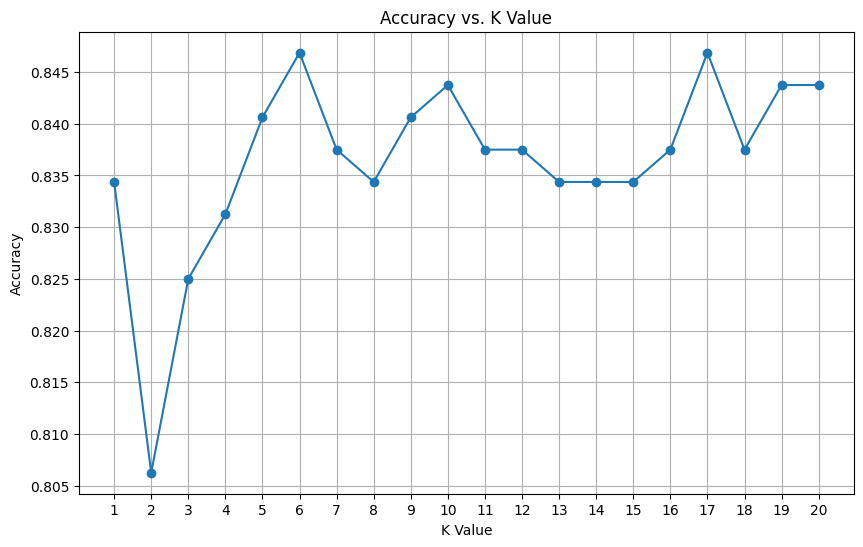

In [21]:
# Plot accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Accuracy vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [22]:
# Find the best k
best_k = k_values[np.argmax(accuracy_scores)]
print(f"\nBest K Value: {best_k}")



Best K Value: 6


In [23]:
#Train model with best K
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)
best_knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=6)

In [24]:
# 4. Create a function to predict wine quality
def predict_wine_quality(features):
    """
    Predicts the quality of a wine given its chemical composition.

    Args:
        features (list): A list of 11 numerical values representing the chemical
                          composition of the wine in the following order:
                          [fixed acidity, volatile acidity, citric acid, residual sugar,
                           chlorides, free sulfur dioxide, total sulfur dioxide, density,
                           pH, sulphates, alcohol]

    Returns:
        str: A string describing the predicted wine quality.
    """
    # Basic error handling
    if len(features) != 11:
        return "Error: Input must contain 11 features."

    # Convert the input list to a NumPy array and reshape it
    input_features = np.array(features).reshape(1, -1)

    # Scale the input features using the same scaler used for training
    input_features_scaled = scaler.transform(input_features)

    # Predict the quality using the best KNN model
    predicted_quality_label = best_knn_model.predict(input_features_scaled)[0]

    # Map the numerical label to a descriptive string
    quality_mapping = {
        0: "low",
        1: "medium",
        2: "high"
    }
    predicted_quality_text = quality_mapping[predicted_quality_label]

    return f"This wine is likely of {predicted_quality_text} quality 🍷"

In [25]:
# Example usage of the prediction function
features = [7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]
prediction = predict_wine_quality(features)
print(f"\nPrediction for example features: {prediction}")


Prediction for example features: This wine is likely of medium quality 🍷


/workspaces/wine_classifier_with_knn/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### **5. Model saving**
**Objective**: Save the model and some critical information we consider necessary


In [29]:
import pickle
import os

model_dict = {
    'model': best_knn_model,
    'scaler': scaler, # Guardamos el scaler para preprocesar datos nuevos igual
    'target_name': 'quality',
    'target_classes': [0, 1, 2],  # Guardar las clases objetivo
    'Author': 'Kleineer Tabata'
}
# Especifica la ruta donde quieres guardar el modelo
models = 'wine_quality_knn_model.pkl'
# Verifica si el directorio existe, si no, créalo
directorio = os.path.dirname(models)
if directorio:
    os.makedirs(directorio, exist_ok=True)
with open(models, 'wb') as file:
    pickle.dump(model_dict, file)

print(f"\nModelo KNN guardado en: {models}")


Modelo KNN guardado en: wine_quality_knn_model.pkl
